In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("transcripts.csv", index_col = 0)
# w_transcript = data[data["Title"].str.contains("Transcript")].reset_index(drop = True)

print(data.shape)
data.head()

(415, 3)


,Comedian,Title,Transcript
0,Chris Rock,Selective Outrage (2023) | Transcript,[slow instrumental music playing]\n[funk drums...
1,Marc Maron,Thinky Pain (2013) | Transcript,[siren wailing]\nI don’t know what you were th...
2,Chelsea Handler,Evolution (2020) | Transcript,Join me in welcoming the author of six number ...
3,Tom Papa,What A Day! (2022) | Transcript,"Premiered on December 13, 2022\nLadies and gen..."
4,Jim Jefferies,High n’ Dry (2023) | Transcript,"Please welcome to the stage, Jim Jefferies!\nH..."


In [3]:
from pprint import pprint

# First, explore the transcripts
sample_transcript = data.loc[0, "Transcript"].split("\n")
sample_transcript = pd.Series(sample_transcript)

def count_brackets(sentence):
    open_brackets = sentence.count("[")
    close_brackets = sentence.count("]")

    if open_brackets == close_brackets:
        return open_brackets

    return -1

num_brackets = sample_transcript.apply(count_brackets)
num_inconsistent = (num_brackets == -1).sum()
num_no_brackets = (num_brackets == 0).sum()
num_multiple_annot = (num_brackets > 1).sum()

print("Number of sentences where brackets do not match up:", num_inconsistent)
print("Number of sentences without annotations:", num_no_brackets)
print("Number of sentences with multiple annotations:", num_multiple_annot)

Number of sentences where brackets do not match up: 0
Number of sentences without annotations: 82
Number of sentences with multiple annotations: 5


In [4]:
# Check that all transcripts do not have inconsitent brackets
inconsistent_idx = []
for row_idx in data.index:
    transcript = data.loc[row_idx, "Transcript"]
    title = data.loc[row_idx, "Title"]
    sentence_split = transcript.split("\n")
    num_brackets_per_sentence = [count_brackets(sentence) for sentence in sentence_split]

    if -1 in num_brackets_per_sentence:
        inconsistent_idx.append(row_idx)
        print(f"{title:<60} Inconsistent transcript")

Douglas (2020) – Transcript                                  Inconsistent transcript
GOING OUT LIVE (2010) – FULL TRANSCRIPT                      Inconsistent transcript
Black Mitzvah (2019) – Transcript                            Inconsistent transcript
Tom Segura Overdoses – This Is Not Happening [Transcript]    Inconsistent transcript
Son of Patricia (2018) – Transcript                          Inconsistent transcript
STANDUP FOR DRUMMERS (2018) – Full Transcript                Inconsistent transcript
Hot And Fluffy (2007) – Transcript                           Inconsistent transcript
I’M NOT FAT … I’M FLUFFY (2009) – Full Transcript            Inconsistent transcript
Completely Normal (2014) – Transcript                        Inconsistent transcript


In [5]:
# Show the line that has the inconsistent bracket
def get_inconsistent_bracket(transcript):
    sentence_split = pd.Series(transcript.split("\n"))
    num_brackets = sentence_split.apply(count_brackets)
    return sentence_split[num_brackets == -1]

sample_inconsistent = data.loc[inconsistent_idx[1], "Transcript"]
get_inconsistent_bracket(sample_inconsistent).iloc[0]

'I know. I picked that little fella up and I held him tightly. I said, “Son, you don’t have to be scared of that, “I’ve seen Comic Relief and I reckon if it all does kick off, “I don’t think the Third World are up for it.” Don’t get me wrong, I do my bit for charity. My attitude to charity has always been, “You give a man a fish, you feed him for a day, “but you teach a man to fish, you saved yourself a fish, haven’t you?” Old northern proverb. We always get the blame. Parents have always got the blame. It doesn’t matter who they are. When Paris Hilton first hit the headlines my mate said, “I blame the parents.” I thought, “There’s so much you can teach a child, then they’re on their own.” You’re tucking your daughter up in bed, “There you go, lots of love, nightie night. “Don’t forget everything I’ve taught you in life. “Always say your prayers before bedtime, “always eat your vegetables and don’t forget, “always play out nicely with your friends. “All right, darling? Nightie night. D

In [6]:
# Drop all transcripts with inconsistent brackets. If we need more data, we will think of a better handling method
clean_transcripts = data.drop(index = inconsistent_idx)

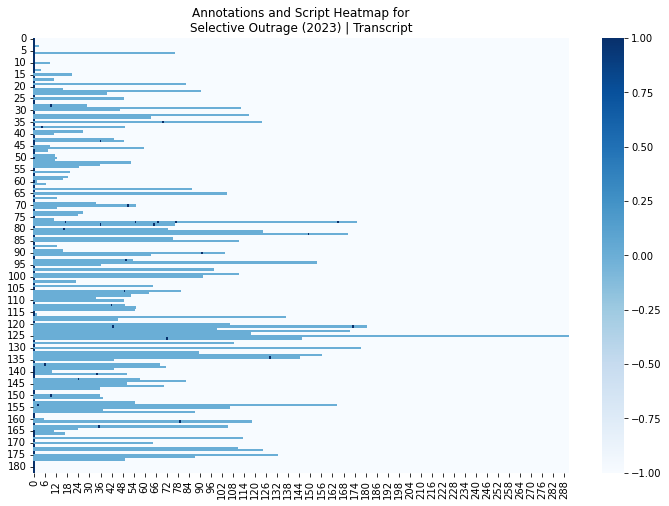

In [7]:
# Plot the distribution of annotations using a heatmap. Every word is one cell, 
# and every cell is 1 if its annotation and 0 if its a normal word

def split_words(sentence):
    sentence_split = sentence.split(" ")
    
    words_w_annot = []
    curr_idx = 0
    while curr_idx < len(sentence_split):
        word = sentence_split[curr_idx]
        if word.startswith("["):

            annot_split = [word]
            while not sentence_split[curr_idx].endswith("]"):
                curr_idx += 1
                annot_split.append(sentence_split[curr_idx])

            words_w_annot.append(" ".join(annot_split))
        
        else:
            words_w_annot.append(sentence_split[curr_idx])
        
        curr_idx += 1

    return words_w_annot


def color_word(word):
    if word is None:
        return -1
    if word.startswith("[") and word.endswith("]"):
        return 1

    return 0
            

def plot_annot_dist(transcript, title):
    sentence_split = transcript.split("\n")
    word_split = [split_words(sentence) for sentence in sentence_split]

    word_matrix = pd.DataFrame(word_split)
    masked_matrix = word_matrix.apply(lambda row: row.apply(color_word))
    
    plt.figure(figsize = (12, 8))
    plt.title(f"Annotations and Script Heatmap for\n{title}")
    sns.heatmap(
        masked_matrix, cmap = "Blues"
    )
    plt.show()

sample_transcript = clean_transcripts.loc[0, "Transcript"]
sample_title = clean_transcripts.loc[0, "Title"]
plot_annot_dist(sample_transcript, sample_title)

Some sentences have multiple annotations, while other sentences only have annotations. There are also sentences that do not have annotations at all. \
Ideally, we would have one annotation per sentence, which would make it easier to handl

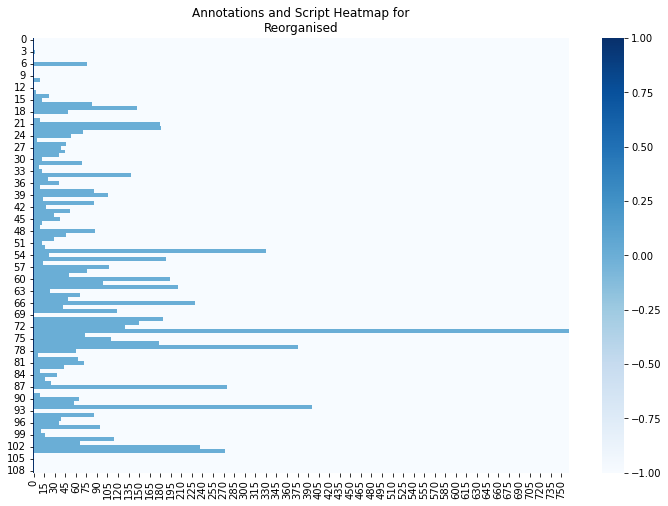

In [8]:
# Reorganise the transcript so that every sentence has at most 1 annotation.

def reorganise_transcript(transcript):
    transcript_soup = transcript.replace("\n", " ")
    return ["[" + sentence.strip() for sentence in transcript_soup.split("[") if sentence != ""]

reorg_transcript = reorganise_transcript(sample_transcript)
plot_annot_dist("\n".join(reorg_transcript), "Reorganised")

In [9]:
# Extract features and labels from the reorganised transcript
# 1. True label if the annotation after the current sentence is a laugh, else False
# 2. Features are TFIDF vectors of the sentence, with respect to the full transcript

def extract_features_labels(transcript):
    reorged = reorganise_transcript(transcript)

    annot_script = [sentence.split("]") for sentence in reorged]
    annots = [pair[0][1: ] for pair in annot_script]
    script = [pair[1].strip() for pair in annot_script]

    # The last sentence cant cause laughter
    labels = [False for _ in range(len(annots))]
    for idx in range(len(annots) - 1):
        laughter = "laugh" in annots[idx].lower()
        labels[idx - 1] = laughter
            
    return pd.DataFrame(zip(labels, script, annots), columns = ["Label", "Script", "Annotation"])


sample_data = extract_features_labels(sample_transcript)
sample_data

,Label,Script,Annotation
0,False,,slow instrumental music playing
1,False,,funk drums playing
2,False,,indistinct chatter
3,False,Let’s go!,man
4,False,,hip-hop music playing
...,...,...,...
104,False,,slams mic
105,False,,audience cheering and applauding
106,False,,hip-hop music playing
107,False,,audience continue cheering


In [10]:
from nltk.corpus import stopwords
import string
import re

punct = string.punctuation
def process_script(script):
    clean1 = script.translate(str.maketrans('', '', punct))         # Remove punctuation
    clean2 = re.sub(r'[^\x00-\x7F]+','', clean1)                    # Remove non-ASCII

    return clean2.lower()

sample_data["Clean Script"] = sample_data["Script"].apply(process_script)

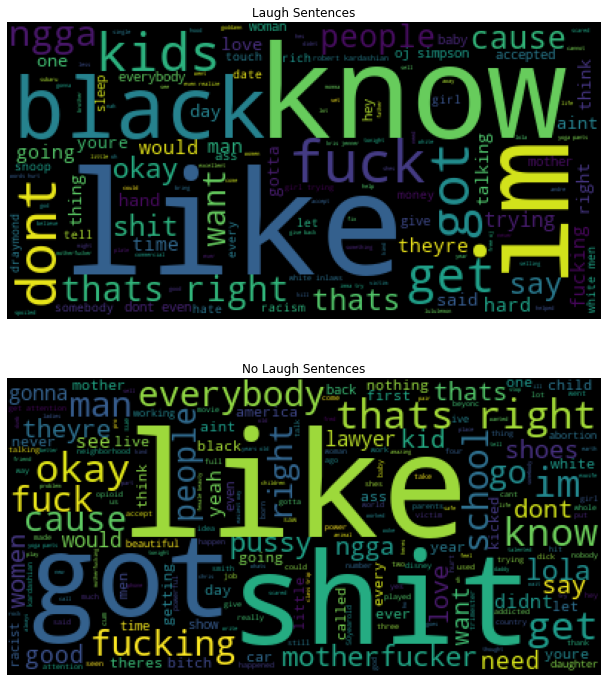

In [20]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
# Show Wordcloud

stop_words = stopwords.words("english")
def plot_wordcloud(transcript_data, stop_words = stop_words):
    laugh = transcript_data[transcript_data["Label"]]
    no_laugh = transcript_data[~transcript_data["Label"]]

    laugh_words = " ".join(laugh["Clean Script"])
    laugh_words = " ".join([word for word in laugh_words.split(" ") if word != ""])

    no_laugh_words = " ".join(no_laugh["Clean Script"])
    no_laugh_words = " ".join([word for word in no_laugh_words.split(" ") if word != ""])

    laugh_cloud = WordCloud(stopwords = stop_words).generate(laugh_words)
    no_laugh_cloud = WordCloud(stopwords = stop_words).generate(no_laugh_words)

    fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 12))
    axs[0].set_title("Laugh Sentences")
    axs[0].imshow(laugh_cloud)
    axs[0].axis("off")

    axs[1].set_title("No Laugh Sentences")
    axs[1].imshow(no_laugh_cloud)
    axs[1].axis("off")
    plt.show()

plot_wordcloud(sample_data)

Every comedian probably has their own choice of filler words, we need to come up with a general enough rule to remove filler words as stopwords from the data

Also, words that appear often probably wont make the audience laugh. They key in comedy is in the unexpected, so we should give more weight to lesser seen words (might work better for some comedians than other comedians)

In [12]:
# Check if there is a visible difference in frequency of words used in laugh sentences vs no laugh sentences

laugh = sample_data[sample_data["Label"]]
no_laugh = sample_data[~sample_data["Label"]]

corpus = " ".join(sample_data["Clean Script"])
corpus = [word for word in corpus.split(" ") if word != ""]

words, counts = np.unique(corpus, return_counts = True)
word_freq = counts / len(corpus)
word_to_freq = {word: freq for word, freq in zip(words, word_freq)}


def get_word_freq(sentence, word_to_freq = word_to_freq):
    words = sentence.split(" ")
    all_freq = [word_to_freq[word] for word in words if word != ""]
    return all_freq

laugh_freq = laugh["Clean Script"].apply(get_word_freq)
no_laugh_freq = no_laugh["Clean Script"].apply(get_word_freq)

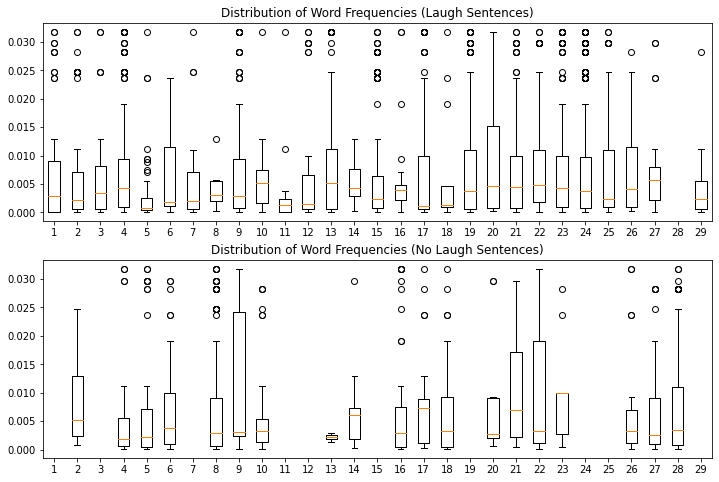

In [13]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 8), sharey = True)
axs[0].set_title("Distribution of Word Frequencies (Laugh Sentences)")
axs[0].boxplot(laugh_freq)

axs[1].set_title("Distribution of Word Frequencies (No Laugh Sentences)")
axs[1].boxplot(no_laugh_freq.sample(29))
plt.show()

Not much significant difference for now. Will probably need to remove filler words from top and bottom until we hit a sweet spot

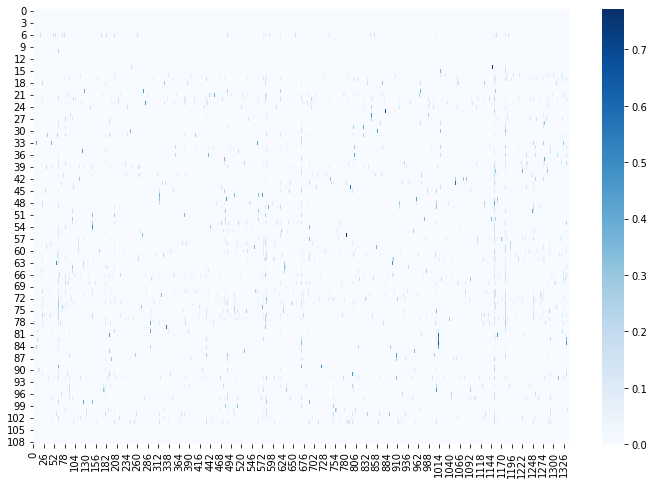

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Examine TFIDF vector

vectorizer = TfidfVectorizer()
vector = vectorizer.fit_transform(sample_data["Clean Script"]).toarray()

plt.figure(figsize = (12, 8))
sns.heatmap(vector, cmap = "Blues")
plt.show()

In [15]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
# Train a naive bayes model with just 1 transcript, and examine its performance
# Evaluate metrics on roc_auc, and cross reference with confusion matrix

# Drop rows where the comedian doesnt say anything
sample_model_data = sample_data[sample_data["Script"] != ""]

X = sample_model_data["Clean Script"]
y = sample_model_data["Label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 242)
train_vec = vectorizer.fit_transform(X_train).toarray()
test_vec = vectorizer.transform(X_test).toarray()

baseline = GaussianNB()
cv_results = cross_validate(baseline, train_vec, y_train, scoring = "roc_auc", return_train_score = True)
cv_summary = pd.DataFrame(cv_results)
cv_summary

,fit_time,score_time,test_score,train_score
0,0.007649,0.009186,0.600000,0.985294
1,0.002994,0.010733,0.347222,1.000000
2,0.005082,0.005989,0.638889,0.984848
3,0.003027,0.008042,0.625000,0.985294
4,0.006580,0.004984,0.562500,1.000000


Overfitting is observed

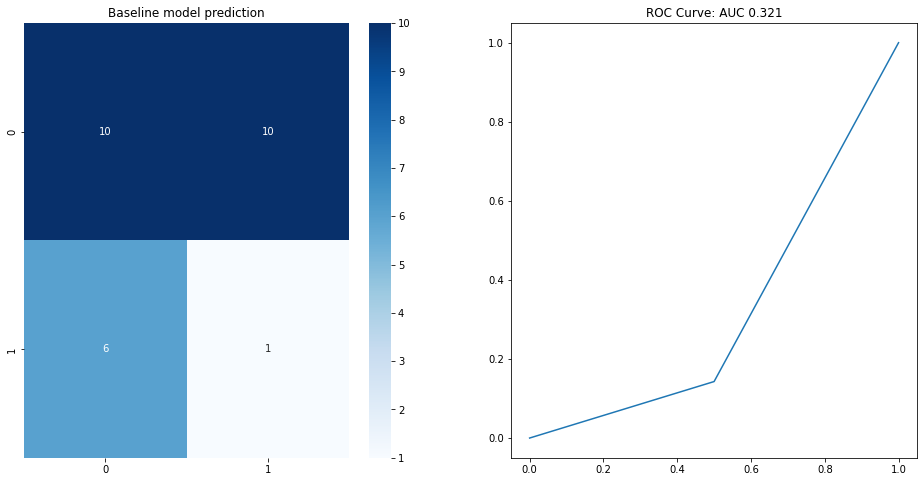

In [16]:
baseline = GaussianNB()
baseline.fit(train_vec, y_train)

def evaluate_cnfm_roc(y, y_prob):
    y_hat = np.argmax(y_prob, axis = 1)
    cnfm = confusion_matrix(y, y_hat)
    roc_auc = roc_auc_score(y, y_hat)

    fpr, tpr, threshold = roc_curve(y, y_prob[:, 1])

    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 8))
    axs[0].set_title("Baseline model prediction")
    sns.heatmap(
        cnfm, cmap = "Blues",
        annot = True, fmt = ".0f",
        ax = axs[0]
    )

    axs[1].set_title(f"ROC Curve: AUC {roc_auc:.3f}")
    axs[1].plot(fpr, tpr)
    plt.show()

y_prob = baseline.predict_proba(test_vec)
evaluate_cnfm_roc(y_test, y_prob)